In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_data, validation_data, test_data = tfds.load('deep_weeds', split=['train[:80%]', 'train[81%:90%]', 'train[91%:]'], as_supervised=True)

TARGET_SIZE = (128, 128)
TARGET_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

train_data = train_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))


#steps = 41
train_data = train_data.shuffle(1024) #.batch(150)
validation_data = validation_data.shuffle(1024) #.batch(25)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of training samples: 14007
Number of validation samples: 1576
Number of test samples: 1576


tf.Tensor(
[[[[0.28921568 0.3745098  0.38333333]
   [0.30490196 0.32058823 0.34215686]
   [0.5421569  0.53039217 0.5480392 ]
   ...
   [0.5421569  0.65294117 0.6382353 ]
   [0.32647058 0.44215685 0.44313726]
   [0.38039216 0.49607843 0.50490195]]

  [[0.26666668 0.3254902  0.327451  ]
   [0.2617647  0.26078433 0.27745098]
   [0.39313725 0.36764705 0.38235295]
   ...
   [0.4480392  0.5411765  0.53137255]
   [0.36862746 0.46862745 0.47254902]
   [0.21862745 0.31764707 0.33235294]]

  [[0.19509804 0.21176471 0.20784314]
   [0.26960784 0.24215686 0.25392157]
   [0.3617647  0.31666666 0.327451  ]
   ...
   [0.40882352 0.47941175 0.47745097]
   [0.36960784 0.43823528 0.44607842]
   [0.25       0.31666666 0.33431372]]

  ...

  [[0.5745098  0.6637255  0.6960784 ]
   [0.4127451  0.53333336 0.53039217]
   [0.32058823 0.48431373 0.42647058]
   ...
   [0.56666666 0.5588235  0.5627451 ]
   [0.6372549  0.62941176 0.6333333 ]
   [0.69803923 0.6901961  0.69411767]]

  [[0.65882355 0.77254903 0.721568

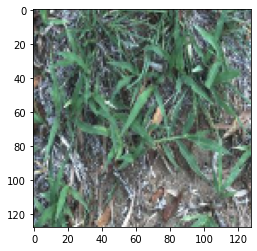

In [3]:
input = keras.Input(shape=TARGET_SHAPE)
normalizer = keras.layers.experimental.preprocessing.Normalization()
preprocess = normalizer(input)
normalizer.set_weights([np.array([0] * 3), np.array([255**2] * 3)])

image_batch, label_batch = next(iter(train_data))
test = normalizer(image_batch)
print(test)
print(label_batch)
plt.imshow(tf.reshape(test, (128, 128, 3)))

In [4]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.GlobalAveragePooling2D(),
])
#base_model.trainable = False
#print(base_model.summary())
#img = train_data.take(1)
#print(img)
#image_batch, label_batch = next(iter(train_data))
#print(image_batch)
#plt.imshow(image_batch / 255.0)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

features = base_model(preprocess)
dense_layer = keras.layers.Dense(512, 
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                     bias_regularizer=keras.regularizers.l2(1e-4),
                                     activity_regularizer=keras.regularizers.l2(1e-5)
                                    )
dropout = keras.layers.Dropout(0.25)
classifier_head = keras.layers.Dense(9, 
                                     activation='softmax',
                                     
                                    )

outputs = classifier_head(dropout(dense_layer(features)))

print(outputs.shape)

model = keras.Model(input, outputs)

print(model.summary())

(None, 9)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
sequential (Sequential)      (None, 1024)              4733952   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 5,263,376
Trainable params: 5,263,369
Non-trainable params: 7
__________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

#print(model.summary())
history = model.fit(train_data.batch(150)
, epochs=20
, validation_data=validation_data.batch(250)
, validation_steps=7
, steps_per_epoch=94
)

#model.save_weights("classifier_head_weights.tf")

Epoch 1/20
